## **Challenge Two: Build a Data Product**  

# Data Preprocessing - 2

In [1]:
# !pip install nlpaug
# !pip install transformers

In [2]:
# Imports required
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from nlpaug.util import Action

In [9]:
# Configuring import properties
tqdm.pandas()
pd.set_option("display.max_rows", None, "display.max_columns", None)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
porter = PorterStemmer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [35]:
df = pd.read_csv('nyc_311_imbalanced.csv', index_col=[0], usecols=[1,2])

In [36]:
df.head()

,text
complaint_type,
PLUMBING,shower stall
CONSTRUCTION,locks
PLUMBING,bathtub
PLUMBING,water leaks
OTHER,rubbish


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

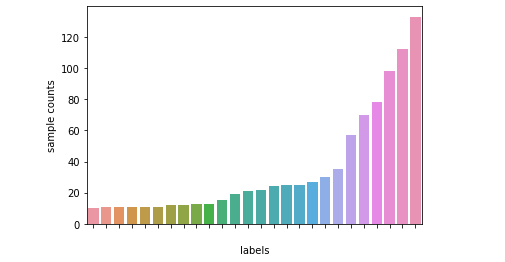

In [5]:
complaint_counts = df['complaint_type'].value_counts(ascending = True)
sns.barplot(complaint_counts.index, complaint_counts)
plt.gca().set_ylabel('sample counts')
plt.gca().set_xlabel('labels')
plt.xticks(color="white")

From the above chart, we can clearly see that our dataset has high **Class Imbalance**.  

Class imbalance is not a pleasant thing to have in a dataset, as it can influence our model to favour the classes with higher samples.  

Hence, we will now fix the class imbalance.

# Data Augmentation for Handling Class Imbalance

Data augmentation is a useful technique to improve performance and outcomes of machine learning models.  
It is done by oversampling the samples with low count, or undersampling the samples with high count.

I will use the **nlpaug** library to perform **oversampling** of data as we already have less data, and I don't want to lose more data by undersampling.  

I am using different augmentation techniques for creating samples, the below defined class talks more about the methods.

In [ ]:
class NLPAugmentation:
    def __init__(self):
        # bert model for insertion of a relevant word in the text
        self.model_bert_insert = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

        # bert model for substituting a word with a synonym
        self.model_bert_substitute = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")
        
        # distilbert model for insertion of a relevant word in the text
        self.model_distilbert_insert = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action="insert")
        
        # distilbert model for substituting a word with a synonym in the text
        self.model_distilbert_substitute = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action="substitute")
        
        # roberta model for substituting a word with a synonym in the text
        self.model_roberta_substitute = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")
        
        # wordnet for replacing synonymous words
        self.model_wordnet = naw.SynonymAug(aug_src='wordnet')
        
        # random word replacement
        self.model_random_word = naw.RandomWordAug(action="swap")
        
        # model for language back-translation to reword the text - new popular technique 
        self.model_translation = naw.BackTranslationAug(from_model_name='facebook/wmt19-en-de', to_model_name='facebook/wmt19-de-en')


    def get_augmented_samples(self, text):
        augmented_samples = []

        augmented_samples.append(self.model_bert_insert.augment(text))
        augmented_samples.append(self.model_bert_substitute.augment(text))
        augmented_samples.append(self.model_distilbert_insert.augment(text))
        augmented_samples.append(self.model_distilbert_substitute.augment(text))
        augmented_samples.append(self.model_roberta_substitute.augment(text))
        augmented_samples.append(self.model_wordnet.augment(text))
        augmented_samples.append(self.model_random_word.augment(text))
        augmented_samples.append(self.model_translation.augment(text))

        return augmented_samples

aug = NLPAugmentation()

# aug.get_augmented_samples(text)

I have defined the augmentation class above, now I will generate augmented samples for the labels with less than 100 samples.

In [10]:
# number of different augmentation functions available in our Aug Class.
num_aug_methods = 8

# traversing over complaint_counts
for complaint_type, count in complaint_counts.items():
    
    # creating a temporary df to store records of the selected complaint_type
    df_temp = df[df['complaint_type'] == complaint_type]

    # number of augmented samples required. 
    required_aug_count = min(100, count*num_aug_methods)

    values = df_temp['text'].values
    
    # new augmented samples will be appended to new_samples list
    new_samples = []
    for text in values:    
        augmented_samples = aug.get_augmented_samples(text)
        new_samples = new_samples + augmented_samples
        count = count + len(augmented_samples)

        # if we have generated required number of samples, break the loop
        if count >= required_aug_count:
            break
    
    # Appending the newly generated samples to the original dataframe
    for text in new_samples:
        df = df.append({'complaint_type': complaint_type, 'text': text },ignore_index=True)

In [13]:
# Random undersampling of labels with more than 110 samples
for complaint_type, count in complaint_counts.items():
    if count >= 110:
        N = abs(100 - count)
        df = df.drop(df[df['complaint_type'].eq(complaint_type)].sample(N).index)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

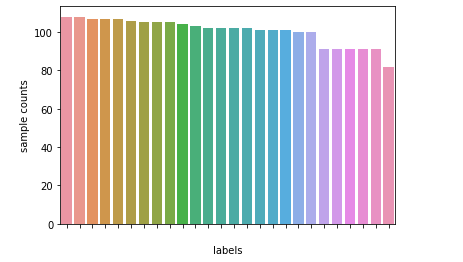

In [15]:
counts = df['complaint_type'].value_counts()
sns.barplot(counts.index, counts)
plt.gca().set_ylabel('sample counts')
plt.gca().set_xlabel('labels')
plt.xticks(color="white")

From the above visualization we can see that all the classes are now balanced.

In [16]:
# Function to preprocess text

def preprocess_text(text):
    
    cleaned_text = text.replace("/", " ")
    
    cleaned_text = cleaned_text.replace(",", "")
    
    cleaned_text = cleaned_text.replace("-", " ")
    
    # Removes all characters present between brackets including the brackets
    cleaned_text = re.sub("[\(\[].*?[\)\]]", "", cleaned_text)
    
    cleaned_text = re.sub(r'\w*\d\w*', '', cleaned_text)
    
    # tokenize the string
    tokens = word_tokenize(cleaned_text)

    # remove punctuation
    words = [word for word in tokens if word.isalpha()]

    # remove stop words
    words = [w for w in words if not w in stop_words]
    
    # join words to form a string
    cleaned_text = ' '.join(words)
    
    # remove extra spaces
    cleaned_text = cleaned_text.strip()
    
    return cleaned_text

In [ ]:
# recleaning data after augmentation
df['text'] = df['text'].progress_apply(preprocess_text)

# drop na values
df = df.dropna(axis=0, how='any')

# Removing rows which have empty complaint descriptions
df = df[df.text != '']

100%|██████████| 2597/2597 [00:00<00:00, 9361.38it/s]


# Label Encoding

In [ ]:
# Using sklearn LabelEndoder to encode numeric labels for complaint_types which is our target variable

le = preprocessing.LabelEncoder()
le.fit(df.complaint_type)
df['labels'] = le.transform(df.complaint_type)

In [ ]:
df.head()

,complaint_type,text,labels
0,PLUMBING,shower stall,17
1,CONSTRUCTION,locks,1
2,PLUMBING,bathtub,17
3,PLUMBING,water leaks,17
4,OTHER,rubbish,16


In [ ]:
# saving the class balanced dataframe
df.to_csv('nyc_311_balanced.csv')

In [ ]:
# saving the dataframe for AutoNLP HuggingFace Training

df_hf = df.rename(columns={'complaint_type': 'target'})
del df_hf['labels']
df_hf.to_csv('hf_nyc_311_balanced.csv')



---

*** END OF NOTEBOOK ***

# Examples of augmented text from nlpaug

In [38]:
text = "The quick brown fox jumps over the lazy dog ."

In [41]:
augmented_samples = aug.get_augmented_samples(text)
print(f"ORIGINAL TEXT: {text}\n")
print(f"AUGMENTED SAMPLES:-\n")
for sample in augmented_samples:
  print(sample)

ORIGINAL TEXT: The quick brown fox jumps over the lazy dog .

AUGMENTED SAMPLES:-

when the quick brown blue fox jumps over the lazy white dog.
the quick cut fox jumps after the wet dog.
even the quick brown fox jumps over with the adorable lazy dog.
the orphaned brown fox jumps among her lazy dog.
The quick brown girl jumps onto her lazy dog.
The nimble brown fox jump over the work shy dog.
Brown the quick fox jumps over lazy the dog.
The speedy brown fox jumps over the lazy dog.


In [42]:
text = "New York is the city that never sleeps"

augmented_samples = aug.get_augmented_samples(text)
print(f"ORIGINAL TEXT: {text}\n")
print(f"AUGMENTED SAMPLES:-\n")
for sample in augmented_samples:
  print(sample)

ORIGINAL TEXT: New York is the city that never sleeps

AUGMENTED SAMPLES:-

now new nueva york is the city that that never sleeps
new york cities and town that never sleeps
new middle york is the newest city bar that never sleeps
new york … our city where never sleeps
New York and the state that ever sleeps
New House of york comprise the city that never slumber
York new the is city that sleeps never
New York is the city that never sleeps
